In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

from finrl.config_tickers import DOW_30_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
# from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.agents.stablebaselines3.models_syn import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

In [2]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [3]:
RESULTS_DIR

'results'

In [4]:
TRAIN_START_DATE = '2009-01-01'
TRAIN_END_DATE = '2015-09-26'
TEST_START_DATE = '2015-09-26'
TEST_END_DATE = '2023-06-01'

df = YahooDownloader(start_date = TRAIN_START_DATE,
                    end_date = TEST_END_DATE,
                    ticker_list = DOW_30_TICKER).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [5]:
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [6]:
processed.sample(5)

,date,open,high,low,close,volume,tic,day,macd,macds,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
95154,2022-01-13,237.500000,238.789993,227.919998,228.630005,6680300,CRM,3,-10.294592,-9.702991,268.355832,222.569166,36.682371,-133.706897,41.926925,251.085334,274.328834,35.464509
22604,2012-02-06,26.549999,26.730000,26.360001,18.993382,36772600,INTC,0,0.385294,0.389250,19.413372,17.557705,61.061227,83.468554,21.042731,18.113581,17.563914,22.516752
75837,2019-05-24,119.209999,119.629997,118.330002,112.970985,2240100,AXP,4,1.514504,1.639748,114.322396,109.350847,60.573444,78.120304,32.497268,110.243818,107.102828,6.912095
34379,2013-09-18,88.910004,89.910004,88.300003,69.053703,10115500,JNJ,2,-0.020308,-0.292204,69.160123,65.688931,55.279480,13.582947,13.779738,68.178373,68.526428,28.898509
68638,2018-05-29,243.860001,243.860001,240.240005,225.025436,2837800,UNH,1,3.142468,3.152383,232.292217,212.451069,55.516383,68.445623,16.586786,221.433142,214.601168,33.027672


In [7]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 29, State Space: 320


In [8]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "buy_cost_pct": 0.001, 
    "sell_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    "print_verbosity":5
    
}

In [9]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [10]:
rebalance_window = 66 # rebalance_window is the number of days to retrain the model
validation_window = 66 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window, 
                 validation_window=validation_window, 
                 **env_kwargs)



In [11]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.509115122471741


In [12]:
df_account_value.head()

,account_value,date,daily_return,datadate
0,1000000.000000,2015-12-31,NaN,2015-12-31
1,998114.098368,2016-01-04,-0.001886,2016-01-04
2,998512.450475,2016-01-05,0.000399,2016-01-05
3,995018.406043,2016-01-06,-0.003499,2016-01-06
4,985983.487261,2016-01-07,-0.009080,2016-01-07


<AxesSubplot:>

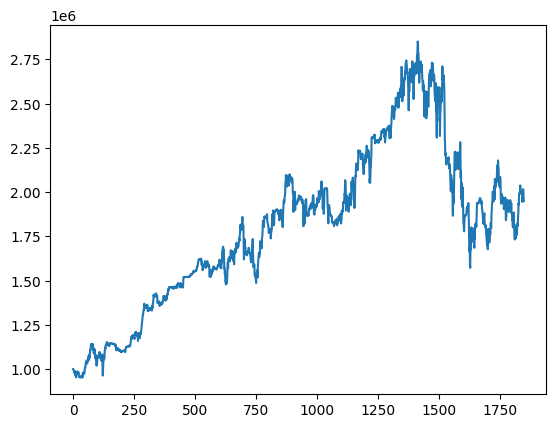

In [13]:
%matplotlib inline
df_account_value.account_value.plot()

In [14]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
Annual return          0.095360
Cumulative returns     0.950226
Annual volatility      0.232060
Sharpe ratio           0.509115
Calmar ratio           0.212573
Stability              0.689463
Max drawdown          -0.448601
Omega ratio            1.102144
Sortino ratio          0.716337
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.040357
Daily value at risk   -0.028768
dtype: float64


In [15]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1847, 8)
Annual return          0.092896
Cumulative returns     0.917600
Annual volatility      0.189607
Sharpe ratio           0.564159
Calmar ratio           0.250487
Stability              0.868292
Max drawdown          -0.370862
Omega ratio            1.121650
Sortino ratio          0.779705
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.905842
Daily value at risk   -0.023464
dtype: float64


==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1847, 8)


Start date,2015-12-31
End date,2023-05-04
Total months,88
,Backtest
Annual return,9.536%
Cumulative returns,95.023%
Annual volatility,23.206%
Sharpe ratio,0.51
Calmar ratio,0.21
Stability,0.69
Max drawdown,-44.86%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,44.86,2021-08-11,2022-06-17,NaT,NaN
1,20.05,2018-10-03,2018-12-24,2019-02-13,96
2,15.74,2016-04-27,2016-06-27,2016-07-20,61
3,13.98,2019-07-15,2019-10-02,2020-08-10,281
4,12.58,2018-06-12,2018-06-27,2018-08-27,55


Stress Events,mean,min,max
New Normal,0.05%,-7.26%,6.71%


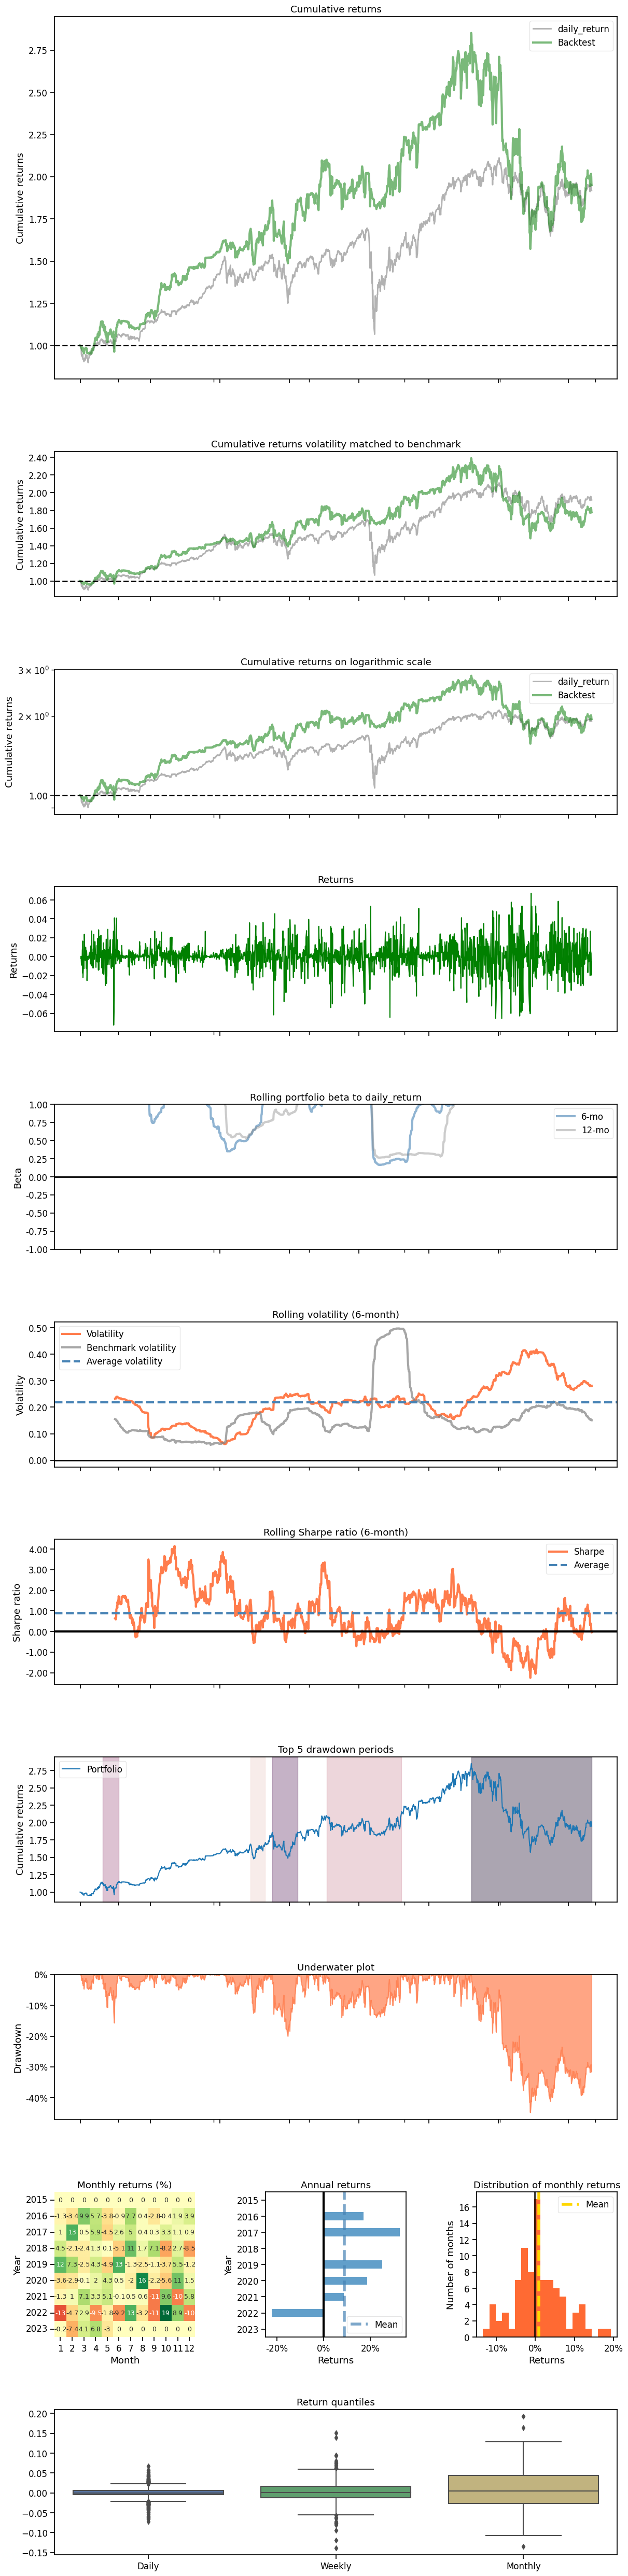

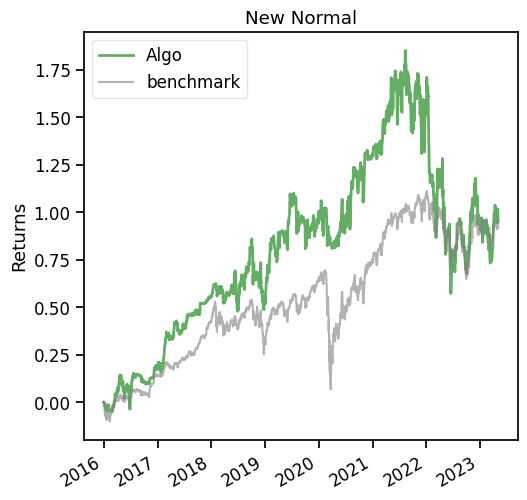

In [16]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
              baseline_ticker = '^DJI', 
              baseline_start = df_account_value.loc[0,'date'],
              baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])